In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score

from utils import load_full_labels, load_full_probas, load_meta_features

In [2]:
DATASETS = [["acm", 10], ["20ng", 10], ["webkb", 10]]

CLFS_SET = [
    ["bert", "temperature_scaling"],
    ["xlnet", "temperature_scaling"],
    ["ktmk", "isotonic"],
    ["ktr", "isotonic"],
    ["lstmk", "isotonic"],
    ["lstr", "isotonic"],
    ["ltr", "isotonic"]
]
CLFS_SET.sort(key=lambda x: x[0])

FEATURES_SET = [
    "probas-based"
]

USE_FS = [
    "probas-based"
]

FEATURES_SET.sort()
STACKING_DIR = "/home/welton/data/stacking/stacking_output"
meta_layer = "multi_output"

idx_to_clf = {idx: clf for idx, (clf, _) in enumerate(CLFS_SET)}

clf_sufix = '/'.join([ f"{c[0]}_{c[1]}" for c in CLFS_SET ])
mf_sufix = '_'.join(FEATURES_SET)


In [3]:
DATA_SOURCE = "/home/welton/data"
STACKING_DIR = f"{DATA_SOURCE}/stacking/stacking_output"
ORACLE_DIR = f"{DATA_SOURCE}/oracle/hard_docs"

In [4]:
pkl = np.load("/home/welton/data/oracle/hard_docs/webkb/bert_temperature_scaling/ktmk_isotonic/ktr_isotonic/lstmk_isotonic/lstr_isotonic/ltr_isotonic/xlnet_temperature_scaling/probas-based/fold_9/output.pkl", allow_pickle=True)

In [5]:
list(pkl.keys())

['avg_macro',
 'full_macro',
 'train_labels',
 'test_labels',
 'train_counts',
 'test_counts',
 'y_pred',
 'importances']

In [6]:
outputs = {}
for dataset, n_folds in DATASETS:
    outputs[dataset] = {}
    for fold in np.arange(n_folds):
        outputs[dataset][fold] = pkl = np.load(f"{ORACLE_DIR}/{dataset}/{clf_sufix}/{mf_sufix}/fold_{fold}/output.pkl", allow_pickle=True)

In [7]:
metrics = {}
for dataset, n_folds in DATASETS:
    metrics[dataset] = {}
    for fold in np.arange(n_folds):
        
        y_test = outputs[dataset][fold]["test_labels"]
        y_pred = outputs[dataset][fold]["y_pred"]
        macro = f1_score(y_test, y_pred, average="macro")
        full_macro = f1_score(y_test, y_pred, average=None)
        
        print(macro, full_macro)
    print(dataset.upper(),"\n\n")

0.7685942031749224 [0.88629118 0.65089723]
0.7448089946628512 [0.87373468 0.61588331]
0.7402228323464504 [0.86797526 0.6124704 ]
0.7567378433500924 [0.88632792 0.62714777]
0.7543754894027126 [0.87985114 0.62889984]
0.7399203674823972 [0.86724231 0.61259843]
0.7526745824673511 [0.87931951 0.62602965]
0.7381375545737816 [0.87817658 0.59809853]
0.765465081010926 [0.88641189 0.64451827]
0.7562194344708599 [0.87374423 0.63869464]
ACM 


0.8106351725868431 [0.95776324 0.66350711]
0.822924157976747 [0.95449029 0.69135802]
0.7953312510274536 [0.94996986 0.64069264]
0.8376072370216705 [0.96189619 0.71331828]
0.8163697685830679 [0.95462795 0.67811159]
0.8458526698508406 [0.96529025 0.72641509]
0.8184158874382497 [0.95793269 0.67889908]
0.8185138897257429 [0.95472501 0.68230277]
0.7981222656939281 [0.95194923 0.6442953 ]
0.8301679782082325 [0.9594431  0.70089286]
20NG 


0.8037627585358162 [0.93156733 0.67595819]
0.79964066288902 [0.92809489 0.67118644]
0.8189752775362265 [0.93363162 0.70431894]


In [8]:
for dataset in outputs:
    scores = []
    for fold in outputs[dataset]:
        y_pred = outputs[dataset][fold]["y_pred"]
        y_test = outputs[dataset][fold]["test_labels"]
        scores.append([
            precision_score(y_test, y_pred, pos_label=0),
            recall_score(y_test, y_pred, pos_label=0)]
        )
    print(np.mean(scores, axis=0))

[0.93262061 0.82932632]
[0.97729344 0.93723254]
[0.93923264 0.90720774]


# Number of docs at each class

In [9]:

for dataset in outputs:
    total_docs = 0
    total_soft = 0
    total_hard = 0
    for fold in outputs[dataset]:
        y_test = outputs[dataset][fold]["test_labels"]
        total = len(y_test)
        n_hard = np.sum(y_test)
        n_soft = total - n_hard

        total_docs += total
        total_soft += n_soft
        total_hard += n_hard

    print(dataset.upper(), f"N Docs: {total_docs}, N Soft: {total_soft}-{100 * (total_soft / total_docs)}, N Hards: {total_hard}-{100 * (total_hard / total_docs)}")

ACM N Docs: 24897, N Soft: 19877-79.83692814395309, N Hards: 5020-20.163071856046912
20NG N Docs: 18846, N Soft: 16942-89.89706038416641, N Hards: 1904-10.102939615833598
WEBKB N Docs: 8199, N Soft: 6841-83.43700451274546, N Hards: 1358-16.562995487254543


# Feature Importance

In [10]:
imps_datasets = {}
for dataset in outputs:
    imps = []
    for fold in outputs[dataset]:
        imps.append(outputs[dataset][fold]["importances"])
    imps_datasets[dataset] = np.mean(imps, axis=0)


In [11]:
features_labels = [
            "Peso da Classe",
            "Acertos na Classe",
            "Confiança",
            "Divergência",
            "Tam. Unanimidade",
            "N Classes Preditas",
            "Entropia das Predições"]

features_labels = [
            "PC",
            "AC",
            "Conf",
            "Div",
            "TU",
            "NCP",
            "EP"]

In [12]:
clfs_labels = [
    "BERT",
    "KNN MFC",
    "KNN TF",
    "SVM MFC",
    "SVM TF",
    "LR TF",
    "XLNet"
]

In [13]:
from itertools import product
import matplotlib.pyplot as plt

In [17]:
xl = np.array([ f"{c}-{f}" for c, f in product(clfs_labels, features_labels) ])
xl

array(['BERT-PC', 'BERT-AC', 'BERT-Conf', 'BERT-Div', 'BERT-TU',
       'BERT-NCP', 'BERT-EP', 'KNN MFC-PC', 'KNN MFC-AC', 'KNN MFC-Conf',
       'KNN MFC-Div', 'KNN MFC-TU', 'KNN MFC-NCP', 'KNN MFC-EP',
       'KNN TF-PC', 'KNN TF-AC', 'KNN TF-Conf', 'KNN TF-Div', 'KNN TF-TU',
       'KNN TF-NCP', 'KNN TF-EP', 'SVM MFC-PC', 'SVM MFC-AC',
       'SVM MFC-Conf', 'SVM MFC-Div', 'SVM MFC-TU', 'SVM MFC-NCP',
       'SVM MFC-EP', 'SVM TF-PC', 'SVM TF-AC', 'SVM TF-Conf',
       'SVM TF-Div', 'SVM TF-TU', 'SVM TF-NCP', 'SVM TF-EP', 'LR TF-PC',
       'LR TF-AC', 'LR TF-Conf', 'LR TF-Div', 'LR TF-TU', 'LR TF-NCP',
       'LR TF-EP', 'XLNet-PC', 'XLNet-AC', 'XLNet-Conf', 'XLNet-Div',
       'XLNet-TU', 'XLNet-NCP', 'XLNet-EP'], dtype='<U12')

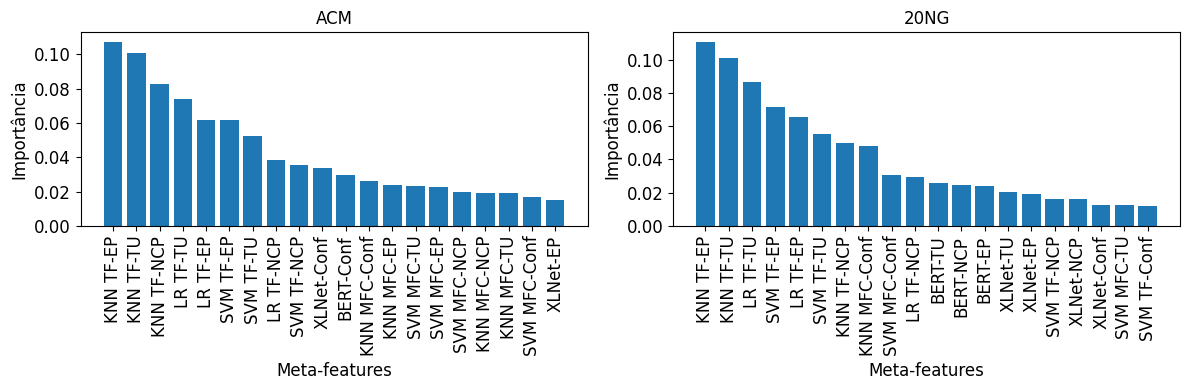

In [19]:

n_feats = 20
fig = plt.figure(figsize=(12,4))
for plot_idx, dataset in enumerate(["acm", "20ng"]):
    sort = (1 - imps_datasets[dataset]).argsort()
    rf = imps_datasets[dataset][sort][:n_feats]
    rl = xl[sort][:n_feats]
    x = np.arange(n_feats)
    plt.subplot(1, 2, plot_idx + 1)
    plt.bar(x, rf)
    plt.xticks(ticks=x, labels=rl, fontsize=12, rotation=90)
    plt.yticks(fontsize=12)
    plt.xlabel("Meta-features", fontsize=12)
    plt.ylabel("Importância", fontsize=12)
    plt.title(dataset.upper(), fontsize=12)
plt.tight_layout()
plt.savefig("data/ranking-mf.pdf")

In [16]:
xtick_labels[sort]

NameError: name 'xtick_labels' is not defined